In [1]:
import cluster as cl
import cluster_ts as cl_ts

import os
import numpy as np
import pandas as pd
import geopandas as gpd

from shapely import wkt
import fiona

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# basemap 
basemap_url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'

# centeral point of Samarra 
df_sites = pd.DataFrame({
    "longitude": [43.823543],
    "latitude": [34.340989],
    "name": ["Samarra Archaeological City"],
    "category": ["Cultural"],
    "date inscribed": ["2007"],
    "region": ["Arab States"],
    "url": ["https://whc.unesco.org/en/list/276"],
    "iso": [["IQ"]]
})

# REQUIRES GOOGLE EARTH ENGINE INITIALIZATION

# Example Data

In [3]:
def create_subregions(chunks, sift_percentage_lon=0.5, sift_percentage_lat=0.415):
    """
        Shifts all polygons to 8 positions based on half the length in longitude and latitude, to create subregions - one for each direction from the center.

        Assumes aoi contains all similar polygons, and are similar to a square.

        Parameters:
            aoi (GeoDataFrame): The area of interest containing geometries.
            sift_percentage (float): Percentage of the length to shift the center point. Default is 0.5 (50%) for half the length.
    """

    if chunks.empty:
        return {}
    
    first_polygon = chunks.geometry.iloc[0]

    # take top two points of the polygon and get the length between them
    top_points = first_polygon.exterior.coords[:2]
    length_lon = abs(top_points[0][0] - top_points[1][0])

    # calculate the shift amount
    shift_amount_lon = length_lon * sift_percentage_lon 
    shift_amount_lat = length_lon * sift_percentage_lat

    shift_directions = {
        "left": (-shift_amount_lon, 0),
        "right": (shift_amount_lon, 0),
        "up": (0, shift_amount_lat),
        "down": (0, -shift_amount_lat),
        "top_left": (-shift_amount_lon, shift_amount_lat),
        "top_right": (shift_amount_lon, shift_amount_lat),
        "bottom_left": (-shift_amount_lon, -shift_amount_lat),
        "bottom_right": (shift_amount_lon, -shift_amount_lat),
    }

    subregions = []
    aoi = chunks.copy()
    aoi = aoi.dissolve()
        
    # Create subregions by shifting the geometries in all directions
    for _, (dx, dy) in shift_directions.items():
        gdf_shifted = chunks.copy()
        gdf_shifted["geometry"] = gdf_shifted["geometry"].translate(dx, dy)

        if subregions is not []:
            for region in subregions:
                for polygon in gdf_shifted.geometry:
                    for region_polygon in region.geometry:
                        if polygon.intersects(region_polygon):
                            # calculate % of intersection
                            intersection = polygon.intersection(region_polygon)
                            intersection_area = intersection.area
                            region_area = region_polygon.area
                            intersection_percentage = intersection_area / region_area if region_area > 0 else 0
                            
                            if intersection_percentage > 0.5: 
                                # if too high of an overlap skip
                                # print(f"Dropping polygon from subregion due to high overlap: {intersection_percentage:.2%} with existing region.")
                                gdf_shifted = gdf_shifted[gdf_shifted.geometry != polygon]
                                break         

        subregions.append(gdf_shifted)

    # Combine all into one GeoDataFrame
    subregions = pd.concat(subregions, ignore_index=True)

    # Reset index and return as GeoDataFrame
    subregions = subregions.reset_index(drop=True)

    return gpd.GeoDataFrame(subregions, crs=chunks.crs)

# Chunks of Samarra Archaeological City 
with fiona.open("chunks_new.shp") as src:
    chunks = gpd.GeoDataFrame.from_features(src, crs=src.crs)

# Create subregions based on the chunks
subregions = create_subregions(chunks)
subregions = pd.concat([subregions, chunks], ignore_index=True)

print(f"Subregions created: {len(subregions)}")

Subregions created: 35


In [6]:
mapping = {
    "NaN": 0,
    np.NaN: 0,
    "None": 0,
    "Water": 1,
    "Wetland": 2,
    "Agricultural": 3,
    "Urban": 4,
    "Wasteland": 5,
} 

data_dir = pd.DataFrame({
    "dir": [f"data/{year}.csv" for year in range(2019, 2025)],
    "year": [year for year in range(2019, 2025)]
})

labels = pd.read_csv("labels_backup_581.csv")
labels['geometry'] = labels['geometry'].apply(wkt.loads)
labels = gpd.GeoDataFrame(labels, geometry='geometry')
labels = labels.set_crs("EPSG:4326", allow_override=True)

In [7]:
from shapely.geometry import shape

def load_zones(dir):
    """
        Loads in polygons zones from a directory containing GeoJSON files.
    """

    files = []

    if dir is not [] and os.path.isfile(dir) and dir.endswith('.geojson'):
        files = [dir]
    else: 
        files = [f for f in os.listdir(dir) if f.endswith('.geojson')]
    polygons = []

    for file in files:
        with fiona.open(os.path.join(dir, file)) as src:
            for feature in src:
                polygons.append(shape(feature['geometry']))

    return polygons    

zones = load_zones("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/zones")
boundary = load_zones("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/zones/boundary")

boundary = gpd.GeoDataFrame(geometry=boundary, crs="EPSG:4326")
zones = gpd.GeoDataFrame(geometry=zones, crs="EPSG:4326")
# extract the geometry from the boundary
boundary_geom = boundary.geometry.values[0]

# Clustering 
Examples of how to load, save, fit and export

In [8]:
# SETUP the class, these you must save yourself if you wish to reload 
# subregion, mapping and data_dir are required, labels can be empty and loaded later 
# requires sequential years of data in data_dir between 2019 and 2024! else this will fail 
# you can use the original cl class to do this yourself if there are year gaps, 
#                                                   ...this class just streamlines the process 
clusterer = cl_ts.cluster_ts(
    ts_point_labels=labels,
    data_dir=data_dir,
    subregions=subregions,
    mapping=mapping,
    start_year=2019,
    end_year=2024,
    passes=3,
    )

#### instansiate_clusters then fit OR load your clusters

In [ ]:
# initialise the clusters (must be done or load the states)
clusterer.instansiate_clusters(
    cluster_class=cl.Cluster, 
    index_column="file_name"
)

In [ ]:
# clusterer.fit(save_state="product/gen_cluster581_15/cluster_") % make sure to fit the data else there will be no sprase matrix 

In [ ]:
# clusterer.create_map(filename_prefix="product/gen_cluster581_15/cluster_") % creates a map based on labels already introduced 

#### load clusters

In [9]:
# load clusters 
file_prefix = "product/gen_cluster900_15/cluster_"

# load the clusters from the file
#   this still requires the setup of the clusterer but no instansiation required
clusterer.load_states(filename_prefix=file_prefix)

Instantiating cluster for year 2019...
Instantiating cluster for year 2020...
Instantiating cluster for year 2021...
Instantiating cluster for year 2022...
Instantiating cluster for year 2023...
Instantiating cluster for year 2024...


In [11]:
clusterer.cluster_list[0].sparse_matrix.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_96,cluster_97,cluster_98,cluster_99,cluster_100,cluster_101,cluster_102,cluster_103,cluster_104,.geo
file_name,,,,,,,,,,,,,,,,,,,,,
tile_43637469_34558614_43638574_34559528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Polygon"",""coordinates"":[[[43.63748527..."
tile_43637484_34557712_43638589_34558626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Polygon"",""coordinates"":[[[43.63749867..."
tile_43637499_34556811_43638603_34557725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Polygon"",""coordinates"":[[[43.63751207..."
tile_43637514_34555909_43638618_34556823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Polygon"",""coordinates"":[[[43.63752986..."
tile_43637528_34555008_43638633_34555922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,7.0,8.0,"{""type"":""Polygon"",""coordinates"":[[[43.63754326..."


# Updating Labels
This is an example using GeeMap, but this is just one way todo it, you can create the with the software/libaries of choice, they just have to fit the year_start, year_end, point format and be a GeoDataframe 

In [12]:
import ee
import geemap
import ipywidgets as widgets
from shapely.geometry import Point
import pandas as pd 

ee.Authenticate()
ee.Initialize(project="jameswilliamchamberlain")

In [13]:
# 
label_list = ['Urban', 'Agricultural', 'Water', 'Wasteland', 'Wetland', 'Other']
date_range = [i for i in range(2019, 2025)] 

collection_name = "COPERNICUS/S2_SR_HARMONIZED"

with fiona.open("aoi.geojson") as src:
    aoi = gpd.GeoDataFrame.from_features(src, crs=src.crs)

In [14]:
# util functions 
def collect_points_from_geemap(map_obj, label):
    """
    Collect all drawn point features from a geemap.Map that uses ee.Feature objects,
    and return them as a GeoDataFrame with a label.

    Parameters:
        map_obj (geemap.Map): The interactive map.
        label (str): Label to assign to all collected points.

    Returns:
        GeoDataFrame: With geometry and 'label' columns.
    """

    features = map_obj.draw_features

    if not features:
        return gpd.GeoDataFrame(columns=["geometry", "label"], geometry="geometry")

    points = []
    for f in features:
        try:
            geom = f.geometry()  # call the method
            if geom.getInfo()["type"] == "Point":
                coords = geom.coordinates().getInfo()  # [lon, lat]
                points.append(Point(coords))
        except Exception as e:
            print("Skipping feature due to error:", e)

    if not points:
        return gpd.GeoDataFrame(columns=["geometry", "label"], geometry="geometry")

    gdf = gpd.GeoDataFrame(geometry=points)
    gdf["label"] = label
    gdf.set_crs("EPSG:4326", inplace=True)
    return gdf

def gen_basemap(basemap_url=None, aoi=gpd.GeoDataFrame(), polygons=None):
    """
        Generates a basemap with the specified URL and adds polygons if provided.

        Parameters:
            basemap_url (str): The URL of the basemap to be used.
            polygons (GeoDataFrame, optional): Polygons to be added to the map. Defaults to None.
            aoi (GeoDataFrame): The area of interest to be displayed on the map. (can be a set of polygons or a single polygon)
        
        Returns:
            geemap.Map: A geemap map object with the specified basemap and polygons.
    """
    m = geemap.Map()

    if not basemap_url:
        basemap_url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
        
    m.add_basemap(basemap_url, name="Google Satellite", attribution="Google")

    # center on aoi
    if not aoi.empty:
        m.add_gdf(aoi, layer_name="AOI", style={"color": "red", "fillColor": "red", "fillOpacity": 0.1})
        center_points = aoi.geometry.unary_union.centroid.coords[0]
        m.setCenter(center_points[0], center_points[1], 10)
    
    if polygons is not None:
        m.add_gdf(polygons, layer_name="Polygons", style={"color": "red", "fillColor": "red", "fillOpacity": 0.1})
    
    return m

In [40]:
# clear labels 
labels = gpd.GeoDataFrame(columns=["label", "geometry", "start_year", "end_year"], geometry="geometry")

#### Simple map below 
below is an example of how labels could be placed, however this is not nessuary this was made for both demonstration purposes of how to place labels. 

if you want to see any tiff files these will need to be loaded in yourself as when i did this i had QGIS up to the side to compare (labels could even be created in QGIS or any software of your choice). 

This may require running through multiple times (map does not require reloading but labels can be refreshed after updatining system)

In [2]:
m = geemap.Map()

def map_polygon(polygon, collection_name, layer_name, yyyymmdd1="2024-01-01", yyyymmdd2="2024-12-29", num_tasks=10):

    # Load in Year Data to Aid in Label Creation
    collection = ee.ImageCollection(collection_name) \
        .filterDate(yyyymmdd1, yyyymmdd2) \
        .filterBounds(polygon) \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20)) \
        .median() \
        .clip(polygon)
    
    vis = {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}

    m.addLayer(collection, vis, layer_name)

    # center map on the polygon
    coords = polygon.geometry().centroid().coordinates().getInfo()
    m.setCenter(coords[0], coords[1], 10)

label_dropdown = widgets.Dropdown(
    options=label_list,
    description='Label:',
    value=label_list[0],
)

# Plots Each Year
for year in date_range:
    map_polygon(geemap.geopandas_to_ee(aoi), collection_name, f"Year {year}", yyyymmdd1=f"{year}-01-01", yyyymmdd2=f"{year}-12-29")

date_slider = widgets.SelectionSlider(
    options=[str(year) for year in range(2019, 2025)], # 2019 to 2024 for full years
    value='2019',
    description='Date:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

time_frame_slider = widgets.SelectionSlider(
    options=[str(month) for month in range(1, 13)], # default 12 as its the full year 
    value='3',
    description='timeframe:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

colour_dict = {
    "Urban": "blue",
    "Agricultural": "green",
    "Water": "cyan",
    "Wasteland": "brown",
    "Wetland": "lightblue", 
} # other is grey by default

def append_label_to_points(b):
    """Appends the selected label to the points in the labels GeoDataFrame."""

    global labels

    selected_label = label_dropdown.value
    start_year = int(date_slider.value)
    span = int(time_frame_slider.value)
    end_year = start_year + span - 1

    # Extract drawn features (assumed to be Points)
    all_drawn_features = m.draw_features
    if not all_drawn_features:
        print("No features drawn.")
        return
    
    points = []
    for feature in all_drawn_features:
        try:
            coords = feature.geometry().coordinates().getInfo()  # [lon, lat]
            point = Point(coords)
            points.append(point)
        except Exception as e:
            print("Skipping feature due to error:", e)

    # create dataframe from points
    new_labels = gpd.GeoDataFrame({
        'label': [selected_label] * len(points),
        'start_year': [start_year] * len(points),
        'end_year': [end_year] * len(points),
        'geometry': points
    }, crs="EPSG:4326")

    # Clear All Drawn Features
    m.draw_control.clear()


    # Append to the existing labels GeoDataFrame
    labels = pd.concat([labels, new_labels], ignore_index=True)
    

# Label Range  
label_output = widgets.Label()
def update_label(*args):
    start_year = int(date_slider.value)
    span = int(time_frame_slider.value)
    end_year = start_year + span - 1
    label_output.value = f"Selected range: {start_year} to {end_year}"

date_slider.observe(update_label, names='value')
time_frame_slider.observe(update_label, names='value')

update_label() 

append_btn = widgets.Button(description="Append Label to Points")
append_btn.on_click(append_label_to_points)

# display(widgets.HBox([date_slider, month_slider, time_frame_slider, render_btn]))
display(widgets.VBox([
    widgets.HBox([date_slider, time_frame_slider]),
    widgets.HBox([label_dropdown, label_output, append_btn]),
]))

m

NameError: name 'geemap' is not defined

In [ ]:
# add from geodataframe
def add_gdf_to_map(gdf, label, colour="Red", fillOpacity=0.5):
    if gdf.empty:
        print("GeoDataFrame is empty, nothing to add.")
        return

    m.add_gdf(gdf, layer_name=label, style={"color": colour, "fillColor": colour, "fillOpacity": fillOpacity})

add_gdf_to_map(zones, "Zones", colour="Red", fillOpacity=0.25)
add_gdf_to_map(boundary, "Boundary", colour="Yellow", fillOpacity=0.0)

In [60]:
# place dots on map for labels
m.add_gdf(labels, layer_name="Labels", style={
    "color": "red",
    "marker": "o",
    "size": 5
})

In [ ]:
labels

In [ ]:
len(labels)

535

In [ ]:
# ignore just kept for ease of use for backing up labels pre-updatining 
# labels.to_csv("labels_temp_new_213.csv", index=False)
# labels = pd.read_csv("labels_temp.csv")

# Update Labels and Review New Map
The functions below are for updatining labels (assumes that clusters have been initiliased first otherwise the update function will not work)

In [61]:
clusterer.update_labels(labels)

Updating labels for cluster 2019
Additional labels provided, merging with existing labels.
Labels after assignment: 1028 total with labels, 374572 tiles without direct labels.
Updating labels for cluster 2020
Additional labels provided, merging with existing labels.
Labels after assignment: 1030 total with labels, 374570 tiles without direct labels.
Updating labels for cluster 2021
Additional labels provided, merging with existing labels.
Labels after assignment: 1030 total with labels, 374570 tiles without direct labels.
Updating labels for cluster 2022
Additional labels provided, merging with existing labels.
Labels after assignment: 1032 total with labels, 374567 tiles without direct labels.
Updating labels for cluster 2023
Additional labels provided, merging with existing labels.
Labels after assignment: 1029 total with labels, 374571 tiles without direct labels.
Updating labels for cluster 2024
Additional labels provided, merging with existing labels.
Labels after assignment: 993 

In [64]:
# save
clusterer.save_states(filename_prefix="product/gen_cluster1206_15/cluster_")

Saving state of cluster 2019 with 375600 labels.
Saving state of cluster 2020 with 375600 labels.
Saving state of cluster 2021 with 375600 labels.
Saving state of cluster 2022 with 375599 labels.
Saving state of cluster 2023 with 375600 labels.
Saving state of cluster 2024 with 312398 labels.


In [63]:
clusterer.create_map(filename_prefix="product/gen_cluster1206_15/cluster_")

Predicting / Creating Map's based on Clusters for year 2019
Predicting / Creating Map's based on Clusters for year 2020
Predicting / Creating Map's based on Clusters for year 2021
Predicting / Creating Map's based on Clusters for year 2022
Predicting / Creating Map's based on Clusters for year 2023
Predicting / Creating Map's based on Clusters for year 2024


# Analysis 

In [ ]:
# load predictions old
# clusterer.cluster_list[0].predictions = pd.read_csv("cluster581/cluster581_2019_predictions.csv").set_index('file_name')
# clusterer.cluster_list[1].predictions = pd.read_csv("cluster581/cluster581_2020_predictions.csv").set_index('file_name')
# clusterer.cluster_list[2].predictions = pd.read_csv("cluster581/cluster581_2021_predictions.csv").set_index('file_name')
# clusterer.cluster_list[3].predictions = pd.read_csv("cluster581/cluster581_2022_predictions.csv").set_index('file_name')
# clusterer.cluster_list[4].predictions = pd.read_csv("cluster581/cluster581_2023_predictions.csv").set_index('file_name')
# clusterer.cluster_list[5].predictions = pd.read_csv("cluster581/cluster581_2023_predictions.csv").set_index('file_name')

In [ ]:
clusterer.cluster_list[5].predictions 

In [28]:
# collect the prediction columns from the clusters
# predictions = clusterer.collect_predictions()

def collect_predictions_by_year(clusterer):
    all_year_dfs = []  # To store each year's predictions
    all_geos = pd.Series(dtype=object)  # To collect the most complete .geo values

    for i, cluster in enumerate(clusterer.cluster_list):
        year = clusterer.start_year + i
        df = cluster.predictions[['predicted_label', '.geo']].copy()

        # Rename prediction column to the year
        df = df.rename(columns={'predicted_label': str(year)})

        # Add to our list of yearly prediction DataFrames
        all_year_dfs.append(df[[str(year)]])

        # Combine geo info for this cluster
        all_geos = all_geos.combine_first(df['.geo'])

    # Outer join on index to merge all yearly predictions
    merged = pd.concat(all_year_dfs, axis=1)

    # Add the unified .geo column
    merged['.geo'] = all_geos

    return merged
    # for cluster in clusterer.cluster_list:
    #     predictions = cluster.create_predictions() 
    #     predictions.append(cluster.predictions['labels'].values)
    
    # return pd.DataFrame(predictions)

merged = collect_predictions_by_year(clusterer)

In [29]:
# save merged predictions
merged.to_csv("product/gen_cluster1206_15/merged_predictions_15_1206.csv", index=True)

In [ ]:
merged = pd.read_csv("product/gen_cluster1206_15/merged_predictions_15_1206.csv", index_col=0)

In [30]:
merged

,2019,2020,2021,2022,2023,2024,.geo
file_name,,,,,,,
tile_43637469_34558614_43638574_34559528,NaN,Wasteland,Wasteland,Wasteland,Wasteland,Wasteland,"{""type"":""Polygon"",""coordinates"":[[[43.63748527..."
tile_43637484_34557712_43638589_34558626,NaN,Wasteland,Wasteland,Wasteland,Wasteland,Wasteland,"{""type"":""Polygon"",""coordinates"":[[[43.63749867..."
tile_43637499_34556811_43638603_34557725,Wasteland,Wasteland,Wasteland,Wasteland,Wasteland,Wasteland,"{""type"":""Polygon"",""coordinates"":[[[43.63751207..."
tile_43637514_34555909_43638618_34556823,Wasteland,Wasteland,Wasteland,Wasteland,Wasteland,Wasteland,"{""type"":""Polygon"",""coordinates"":[[[43.63752986..."
tile_43637528_34555008_43638633_34555922,Wasteland,Wasteland,Wasteland,Wasteland,Wasteland,Wasteland,"{""type"":""Polygon"",""coordinates"":[[[43.63754326..."
...,...,...,...,...,...,...,...
tile_44187802_33891657_44188892_33892565,Agricultural,Agricultural,Agricultural,Agricultural,Agricultural,NaN,"{""type"":""Polygon"",""coordinates"":[[[44.18780074..."
tile_44187810_33890755_44188900_33891664,Agricultural,Agricultural,Agricultural,Agricultural,Agricultural,Agricultural,"{""type"":""Polygon"",""coordinates"":[[[44.18780972..."
tile_44187819_33889853_44188909_33890762,Agricultural,Agricultural,Agricultural,Agricultural,Agricultural,Agricultural,"{""type"":""Polygon"",""coordinates"":[[[44.18781862..."


In [1]:
# boundary_geom = gpd.GeoDataFrame(geometry=boundary, crs="EPSG:4326")

In [67]:
# clip to region 
import utils as ut

gdf_in, gdf_out = ut.clip_to_polygon(boundary_geom, merged)
print(len(gdf_in), len(gdf_out))

47881 327719


In [68]:
gdf_in.drop(columns=['file_name'], inplace=True)

In [69]:
gdf_in

,2019,2020,2021,2022,2023,2024,.geo,geometry
file_name,,,,,,,,
tile_43763000_34398538_43764101_34399451,NaN,Agricultural,Agricultural,Wetland,Wetland,Agricultural,"{""type"":""Polygon"",""coordinates"":[[[43.76301343...","POLYGON ((43.763 34.399, 43.764 34.399, 43.764..."
tile_43763013_34397637_43764114_34398549,NaN,Agricultural,Agricultural,Wetland,Agricultural,Agricultural,"{""type"":""Polygon"",""coordinates"":[[[43.76302679...","POLYGON ((43.763 34.398, 43.764 34.398, 43.764..."
tile_43763027_34396735_43764128_34397648,Urban,Agricultural,Agricultural,Urban,Urban,Urban,"{""type"":""Polygon"",""coordinates"":[[[43.76304016...","POLYGON ((43.763 34.397, 43.764 34.397, 43.764..."
tile_43763040_34395833_43764141_34396746,Urban,Agricultural,Agricultural,Urban,Agricultural,Agricultural,"{""type"":""Polygon"",""coordinates"":[[[43.76305360...","POLYGON ((43.763 34.396, 43.764 34.396, 43.764..."
tile_43763053_34394932_43764154_34395844,Urban,Agricultural,Agricultural,Wetland,Wetland,Agricultural,"{""type"":""Polygon"",""coordinates"":[[[43.76306696...","POLYGON ((43.763 34.395, 43.764 34.395, 43.764..."
...,...,...,...,...,...,...,...,...
tile_44027976_34156542_44029071_34157452,Agricultural,Agricultural,Agricultural,Agricultural,Agricultural,Agricultural,"{""type"":""Polygon"",""coordinates"":[[[44.02797764...","POLYGON ((44.028 34.157, 44.028 34.157, 44.029..."
tile_44027986_34155640_44029081_34156550,Urban,Agricultural,Urban,Agricultural,Agricultural,Agricultural,"{""type"":""Polygon"",""coordinates"":[[[44.02798658...","POLYGON ((44.028 34.157, 44.028 34.156, 44.029..."
tile_44027996_34154738_44029091_34155649,Wasteland,Wasteland,Wasteland,Wasteland,Agricultural,Agricultural,"{""type"":""Polygon"",""coordinates"":[[[44.02799551...","POLYGON ((44.028 34.156, 44.028 34.155, 44.029..."


In [70]:
# drop duplicates based on index
gdf_in = gdf_in.drop_duplicates(subset=['.geo'])

In [71]:
class_totals_per_year = gdf_in.iloc[:, :6].apply(pd.Series.value_counts)
class_totals_per_year

,2019,2020,2021,2022,2023,2024
Agricultural,22571,24471,28115,21635,26609,28159
Urban,2428,3663,3844,4595,3687,4275
Wasteland,15365,12508,11595,17574,12690,10876
Water,2433,2427,2298,2000,2344,1941
Wetland,4990,4812,2029,2077,2551,2578


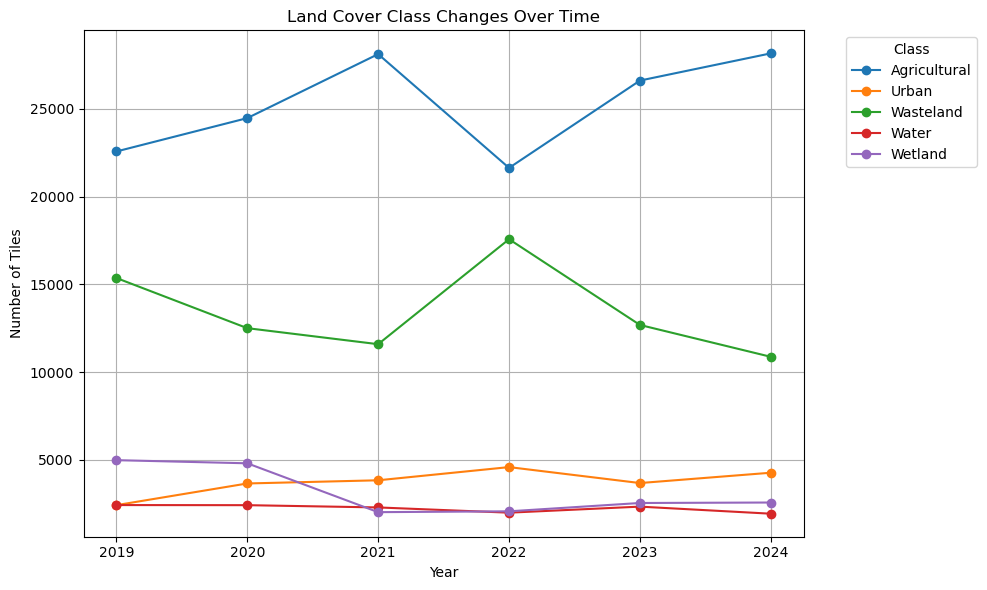

In [72]:
class_totals_per_year = class_totals_per_year.sort_index()

# Transpose: years on x-axis, classes as lines
class_totals_per_year.T.plot(kind='line', marker='o', figsize=(10, 6))

plt.title("Land Cover Class Changes Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Tiles")
plt.grid(True)
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# SOME OLD CODE BELOW 
this is some leftover bits from analysis

In [ ]:
# 2019 
data_2019 = clusterer.cluster_list[0].data
labels_2019 = clusterer.cluster_list[0].predictions

In [ ]:
# data_2019
urban_ids = labels_2019[labels_2019['predicted_label'] == "Urban"].index
urban_data_2019 = data_2019.loc[data_2019.index.isin(urban_ids)]
urban_data_2019_summary = ut.summarise(urban_data_2019)
ut.create_figs(urban_data_2019_summary)

In [ ]:
# agriculture 
agriculture_ids = labels_2019[labels_2019['predicted_label'] == "Agricultural"].index
agriculture_data_2019 = data_2019.loc[data_2019.index.isin(agriculture_ids)]
agriculture_data_2019_summary = ut.summarise(agriculture_data_2019)
ut.create_figs(agriculture_data_2019_summary)

In [ ]:
# urban_vs_agriculture = agriculture_data_2019_summary - urban_data_2019_summary 
urban_vs_agriculture = urban_data_2019_summary - agriculture_data_2019_summary
urban_vs_agriculture = urban_vs_agriculture.abs()
ut.create_figs(urban_vs_agriculture)

In [ ]:
# urban_vs_agriculture = agriculture_data_2019_summary - urban_data_2019_summary 
urban_vs_agriculture = agriculture_data_2019_summary - urban_data_2019_summary 
ut.create_figs(urban_vs_agriculture)

In [ ]:
background_values = data_2019.copy()
backgorund_summary = ut.summarise(background_values)
ut.create_figs(backgorund_summary)

In [ ]:
gdf_in_2019, gdf_out_2019 = ut.clip_to_polygon(boundary_geom, data_2019.copy())
print(len(gdf_in_2019), len(gdf_out_2019))

In [ ]:
background_values = gdf_in_2019.copy()
backgorund_summary = ut.summarise(background_values)
ut.create_figs(backgorund_summary)